# Natural Language Processing

So what is natural language processing? What kinds of data falls into the "natural language" bucket? What types of data are similar that you've already seen?

- We can think of natural language as anything involving human communication - such as text documents, voice recordings
- Typically, when we talk about "natural language processing" we're talking about text data - although it could also include sound data
- Language data is actually quite similar to time series data - the sequence of language data is an important, defining characteristic


## Processing Text Data

Using the 'Spooky Authors' dataset: https://www.kaggle.com/c/spooky-author-identification/overview

Goal: determine whether a chunk of text was written by Edgar Allen Poe, HP Lovecraft or Mary Shelley (multi-class classification problem)

In [1]:
# Wall of imports
import pandas as pd
import string
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix

First let's grab the dataset and look at a few aspects of this dataset (shape, some examples, etc). We'll be using just the train csv for this, for ease of use!

In [2]:
# Grab the train set from the competition 
df = pd.read_csv("spooky-author-identification/train.csv")

In [3]:
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [4]:
df.shape

(19579, 3)

In [5]:
# Exploring an example of one of the texts
df['text'][0]

'This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.'

In [6]:
# Encoding our target from author initials to numbers
le = LabelEncoder()
df['target'] = le.fit_transform(df['author'])

In [7]:
# Checking that change
df.head()

,id,text,author,target
0,id26305,"This process, however, afforded me no means of...",EAP,0
1,id17569,It never once occurred to me that the fumbling...,HPL,1
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,0
3,id27763,How lovely is spring As we looked from Windsor...,MWS,2
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,1


In [8]:
# Grabbing our inputs and target
X = df['text']
y = df['target']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [9]:
# Grabbing a list of stopwords from NLTK, imported above
# We're also using the string library add punctuation to our list
stopwords_list = stopwords.words('english') + list(string.punctuation)

In [10]:
stopwords_list[:20]

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his']

What is the point of a list of stopwords? How/why will we use this list?

- "stopwords" have no inherent meaning and provide no use to a machine who doesn't care about grammar - we'll use this list to remove these words from our texts, so the algorithm focuses on words that actually might distinguish one author from another


### "Bag of Words" - Count Vectorizer

Useful link to the 'User Guide' part of the documentation on this: https://scikit-learn.org/stable/modules/feature_extraction.html#common-vectorizer-usage

In [11]:
# Intstantiating our vectorizer
count_vectorizer = CountVectorizer()

# Training on the train set, then transforming the train set
X_count_train = count_vectorizer.fit_transform(X_train)
# Transforming the test set
X_count_test = count_vectorizer.transform(X_test)

In [12]:
# Instantiating a classifier to use on this text - Multinomial Naive Bayes
nb_classifier = MultinomialNB()

# Fitting the classifier
nb_classifier.fit(X_count_train, y_train)

# Getting our predictions for the train and test sets
train_preds = nb_classifier.predict(X_count_train)
test_preds = nb_classifier.predict(X_count_test)

0.8330949948927477


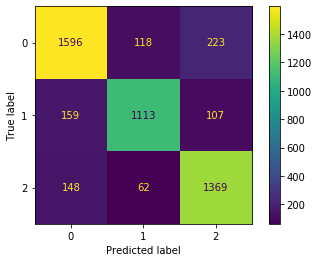

In [13]:
# Let's see how we did!
print(accuracy_score(y_test, test_preds))
plot_confusion_matrix(nb_classifier, X_count_test, y_test,
                      values_format=".4g")  # to make numbers readable
plt.show()

Discuss! How did we do? What could we change?

- fairly high accuracy right off the bat, doesn't appear to favor one class over another too much
- did we even use our stopwords list?


We're about to try this on a few different vectorizers, so let's make that easier!

Here, I'm writing a function where we can provide an instantiated vectorizer, an instantiated classifer, and all of our train and test data, and the function will spit out the accuracy score and confusion matrix just like above:

In [14]:
def classify_vectorized_text(vectorizer, classifier, Xtrain, Xtest, ytrain, ytest):
    '''
    Fit and transform text data using the provided vectorizer, then fit and 
    predict with the provided classifier, in order to see the resulting
    accuracy score and confusion matrix
    For the Xtrain, Xtest, ytrain, ytest, expect the output of an
    sklearn train/test split
    -
    Inputs:
    vectorizer: an instantiated sklearn vectorizer
    classifier: an instantiated sklearn classifier
    X_train: training input data
    X_test: testing input data
    y_train: training true result
    y_test: testing true result
    -
    Outputs: 
    train_preds: predicted results for the train set
    test_preds: predicted results for the test set
    '''

    Xtrain_transformed = vectorizer.fit_transform(Xtrain)
    Xtest_transformed = vectorizer.transform(Xtest)

    classifier.fit(Xtrain_transformed, ytrain)

    train_preds = classifier.predict(Xtrain_transformed)
    test_preds = classifier.predict(Xtest_transformed)

    print(accuracy_score(ytest, test_preds))
    plot_confusion_matrix(classifier, Xtest_transformed, ytest,
                          values_format=".4g")  # to make numbers readable
    plt.show()

    return(train_preds, test_preds)

Let's add in something that was missing from our first Count Vectorizer:

Link to the documentation: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [15]:
# Intstantiating a count vectorizer that removes stop words
count_stop = CountVectorizer(stop_words = stopwords_list)

Now let's create a new classifier and compare the results, using our previously-defined function!

0.8286006128702758


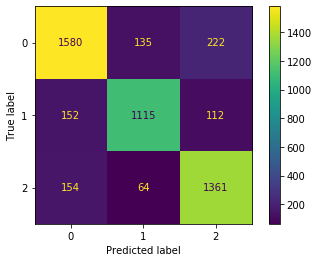

In [16]:
# Trying the same classifier, but now with stopwords removed
nb_stop = MultinomialNB()

stop_train_preds, stop_test_preds = classify_vectorized_text(
    count_stop, nb_stop, X_train, X_test, y_train, y_test)

Compare/discuss: 

- slightly worse accuracy than before! but not drastically so - actually correctly classifies a few more "Class 1" than before, but got worse on "Class 0" and "Class 2"
- what does it mean for stopwords to help our classifier? is our machine learning algorithm learning the right things, or just found that maybe one author uses more pronouns or something than other authors? hard to tell!


### TF-IDF: Term-Frequency - Inverse Document-Frequency

Woah, that's a term and a half. What even is it?

From [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html):

> "The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus."

Basically, it's a statistic that hopefully reflects how important a word is in the document. By looking at the overall frequency you find how common a word is across the whole corpus, compared to the document frequency that shows how common a word is within the document in question. If a word appears often in our document, but relatively rarely in the corpus, it probably captures an important word in that specific document!

In this example, the training corpus is every sentence in the `text` column in our train set, and the document is the individual sentence that we're trying to classify (per row).

Reference: http://www.tfidf.com/

We'll be using Sklearn's [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html), which is 'equivalent to CountVectorizer followed by TfidfTransformer'

In [17]:
# Instantiating the TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words=stopwords_list, use_idf=True)

# Training on the train set, then transforming the train set
tfidf_train = tfidf.fit_transform(X_train)
# Transforming the test set
tfidf_test = tfidf.transform(X_test)

In [18]:
tfidf_df = pd.DataFrame(tfidf.idf_, index=tfidf.get_feature_names(),columns=["idf_weights"])

In [19]:
tfidf_df.sort_values(by='idf_weights', ascending=False).head(10)

,idf_weights
aaem,9.901435
louisa,9.901435
loutish,9.901435
loveless,9.901435
lovingly,9.901435
lowed,9.901435
lowell,9.901435
lowness,9.901435
loyalty,9.901435
lucan,9.901435


In [20]:
# Let's look at a specific example for one row
tfidf_test_df = pd.DataFrame(tfidf_test.toarray(), columns=tfidf.vocabulary_.keys())

test_doc = tfidf_test_df.iloc[16]
print(test_doc.idxmax(axis=1))
print(test_doc[test_doc.idxmax(axis=1)])

chivalry
0.5980220284052462


This tells you that for the 17th document in our test set, the word 'chivalry' has the highest TF-IDF value.

What does this tell you about the word "chivalry" in the this document of our test set?

- occurs relatively infrequently in the corpus, but appears in this document, so likely is important to this document


0.8106230847803881


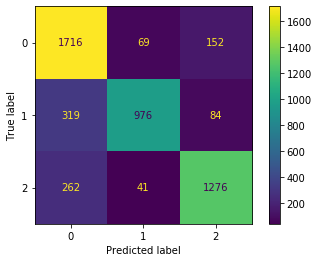

In [21]:
# Using our function to compare the results...
tfidf = TfidfVectorizer(stop_words=stopwords_list, use_idf=True)
nb_tfidf = MultinomialNB()

tfidf_train_preds, tfidf_test_preds = classify_vectorized_text(tfidf, nb_tfidf, X_train, X_test, y_train, y_test)

Compare/discuss:

- getting even worse! but not drastically so. now, we're better at classifying "Class 0" but worse at classifying "Class 1" and "Class 2"


0.7082737487231869


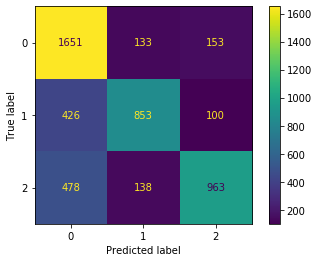

In [22]:
# We can also use our function to try different classifiers
tfidf = TfidfVectorizer(stop_words=stopwords_list, use_idf=True)
rfc = RandomForestClassifier(n_estimators=100)

rfc_train_preds, rfc_test_preds = classify_vectorized_text(tfidf, rfc, X_train, X_test, y_train, y_test)

Compare/discuss: 

- woah that got way worse, so multinomial naive bayes is probably a better model to capture the relationship between and within these texts than this untuned random forest ensemble
